In [4]:
import numpy as np
import pandas as pd

import czifile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns

from skimage.feature import blob_doh, blob_dog, blob_log
from skimage.color import rgb2gray #to turn into grayscale

from ipywidgets import interact #for interations

#clustering
from sklearn.cluster import DBSCAN
from skimage import filters, measure, segmentation, feature, img_as_ubyte, morphology

from scipy import ndimage as ndi

# Preprocessing

In [5]:
# reading in images
array1 = czifile.imread("/Users/samanthatang/Desktop/stack_data/dmel_st14__i_63x-02.czi")

# (time, channel, z-stack, y-axis, and x-axis), 0 is the dot's channel
array1 = array1.squeeze() #get rid of unwanted channels
array1.shape

(6, 2, 21, 928, 1389)

In [6]:
#preprocessing: 
zstack = array1[1, 0, :, ...] #MS2 (dots) #FIRST TIMEPOINT
IM_MAX = np.max(zstack, axis=0) #maximum projection 
image_gray = rgb2gray(IM_MAX)
image_gray

array([[ 7453,  7628, 10789, ...,  6989,  8890,  6306],
       [ 6192,  9964,  7815, ...,  6735,  6735,  8884],
       [ 8016,  6504,  7239, ...,  7568,  5915,  7384],
       ...,
       [ 8899,  9331,  7779, ...,  8431,  5919,  6754],
       [ 6978,  5778,  7388, ...,  6101,  4978,  4338],
       [ 7466,  6192,  6610, ...,  7342,  4612,  6162]], dtype=uint16)

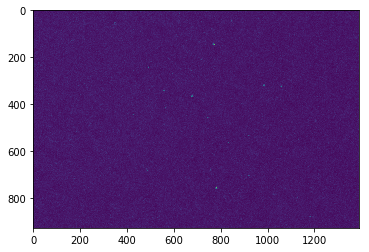

In [7]:
#original image: 
plt.imshow(IM_MAX);

# MS2 dots

We'll begin by taking a look at the MS2 dots and figuring out a way to cluster each dot into its own group throughout timepoints.

The two functions below are used to conveniently show how the dots are detected and to gather the coordinates of each dot into a dataframe by timepoints.

Notice that the first image/dataframe set uses the blob_doh algorithm and the second image/dataframe set uses the blob_dog algorithm. More information about these algorithms can be found [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html).

In [9]:
#function to display image and create dataframe: 

def show_blobs(blobs_coords): 
    
    fig, ax = plt.subplots() #created ax just to add patches
    plt.imshow(IM_MAX)

    for idx in range(len(blobs_coords)):
        for blob in blobs_coords: 
            y, x, r = blob
            c = plt.Circle((x, y), r, color="lime", linewidth=2, fill=False)
            ax.add_patch(c)


    #make into dataframe first (no cleaning)
    x = [arr[1] for arr in blobs_coords] #note, the x and y coordinates are returned in opposite order hence the indexing
    y = [arr[0] for arr in blobs_coords]
    sd = [arr[2] for arr in blobs_coords]
    timepoint_1 = pd.DataFrame({"dots": np.arange(1, len(blobs_coords)+1), "x":x, "y":y, "sd":sd})
    
    return timepoint_1

In [10]:
def timepoint_df(blobs_coords, tp): 
    #make into dataframe first (no cleaning)
    x = [arr[1] for arr in blobs_coords] #note, the x and y coordinates are returned in opposite order hence the indexing
    y = [arr[0] for arr in blobs_coords]
    sd = [arr[2] for arr in blobs_coords]
    timepoint = pd.DataFrame({"dots": np.arange(1, len(blobs_coords)+1), 
                              "x":x, 
                              "y":y, 
                              "sd":sd, 
                              "timept": np.zeros(len(blobs_coords)) + tp})
    
    return timepoint

In [19]:
blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.005) 

,dots,x,y,sd
0,1,781.0,755.0,4.222222
1,2,1386.0,531.0,1.000000
2,3,677.0,365.0,4.222222
3,4,571.0,351.0,1.000000
4,5,557.0,342.0,4.222222
5,6,1057.0,325.0,4.222222
6,7,858.0,307.0,1.000000
7,8,768.0,143.0,7.444444
8,9,740.0,43.0,1.000000


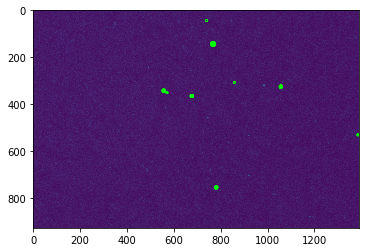

In [11]:
show_blobs(blobs_doh)

,dots,x,y,sd
0,1,1180.0,879.0,2.560
1,2,781.0,756.0,4.096
2,3,487.0,681.0,4.096
3,4,756.0,680.0,2.560
4,5,1111.0,604.0,2.560
5,6,831.0,564.0,2.560
6,7,634.0,515.0,2.560
7,8,1203.0,472.0,2.560
8,9,744.0,458.0,2.560
9,10,350.0,431.0,4.096


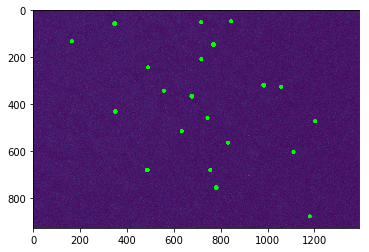

In [12]:
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.08) 
show_blobs(blobs_dog)

There are a couple of blob detection methods that can be used (blob_doh, blob_dog, blob_log) and each one has its own advantages and disadvantages. But after comparing some of the outputs, I decided that the blob_dog algorithm works best with our current set of images. 

- The blob-doh algorithm seems to miss out on some of the more faint dots and supposedly has a harder time detecting small dots/blobs (< 3 pixels) accurately according to the documentation. As for the blob-log alogrithm, it takes too long and doesn't seem to have too much more of an advantage than the blob-dog one. 

- A lower threshold for the blob-dog algorithm captures the faint dots which we may not be able to see with our eyes (because it's some small). We can adjust for the threshold value later on (and figure out a way to automate this process).

Some references to read: https://en.wikipedia.org/wiki/Blob_detection#The_determinant_of_the_Hessian (blob detection algorithm)


Previously above we showcased how the blob detection algorithm works for the maximum projection image of one timepoint. Now, we will implement the same blob detection algorithm for all timepoints and aggregate the coordinates of all MS2 dots into one dataframe.

In [30]:
def all_timepoints_combined(total_tp, array):
    
    df = pd.DataFrame() #initalize
    
    for i in range(total_tp): 
        zstack = array[i, 0, :, ...] #MS2 (dots) 
        IM_MAX = np.max(zstack, axis=0) #maximum projection 
        image_gray = rgb2gray(IM_MAX)
        
        blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.08)
        timepoint = timepoint_df(blobs_dog, i)
        df = df.append(timepoint).reset_index(drop=True)
    
    return df



In [31]:
array1_timepoints = all_timepoints_combined(6, array1)

In [32]:
array1_timepoints.head()

,dots,x,y,sd,timept
0,1,393.0,927.0,16.777216,0.0
1,2,1180.0,874.0,2.560000,0.0
2,3,918.0,705.0,2.560000,0.0
3,4,486.0,670.0,2.560000,0.0
4,5,738.0,568.0,2.560000,0.0


As a sanity check, below is a visual movie/slideshow representation of the dots that were isolated via the algorithm above: 

In [33]:
temp = array1_timepoints[["x", "y", "timept"]].groupby("timept").agg(list)
temp

,x,y
timept,,
0.0,"[393.0, 1180.0, 918.0, 486.0, 738.0, 659.0, 11...","[927.0, 874.0, 705.0, 670.0, 568.0, 560.0, 552..."
1.0,"[1180.0, 781.0, 487.0, 756.0, 1111.0, 831.0, 6...","[879.0, 756.0, 681.0, 680.0, 604.0, 564.0, 515..."
2.0,"[171.0, 788.0, 577.0, 926.0, 431.0, 494.0, 764...","[839.0, 770.0, 769.0, 718.0, 701.0, 691.0, 687..."
3.0,"[781.0, 926.0, 429.0, 770.0, 636.0, 746.0, 558...","[769.0, 719.0, 697.0, 696.0, 511.0, 451.0, 410..."
4.0,"[172.0, 779.0, 431.0, 777.0, 1129.0, 745.0, 10...","[836.0, 772.0, 704.0, 691.0, 619.0, 580.0, 556..."
5.0,"[1189.0, 1042.0, 856.0, 762.0, 680.0, 610.0, 5...","[927.0, 927.0, 927.0, 927.0, 927.0, 927.0, 927..."


In [34]:

@interact(index=(0, 5))
def scatter(index=0): 
    x = temp.iloc[index,:]["x"]
    y = temp.iloc[index,:]["y"]
    plt.scatter(x, y)
    
    #formatting:
    plt.xlim([0, 1400])
    plt.xticks(np.arange(0, 1400, 200))
    plt.ylim([1000, 0])
    plt.yticks(np.arange(0, 1000, 200))

interactive(children=(IntSlider(value=0, description='index', max=5), Output()), _dom_classes=('widget-interac…

In [35]:
@interact(i=(0,5))
def show_images(i=5):
    zstack = array1[i, 0, :, ...] #MS2 (dots)
    IM_MAX = np.max(zstack, axis=0) #maximum projection 
    plt.imshow(IM_MAX)

interactive(children=(IntSlider(value=5, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

You'll notice in our little widget, that as we move through the timepoints, there is a "weird" image for the last timepoint. We don't want this "weird" image, so we will ultimately ignore this last timepoint in our dataframe.

# Clustering

Now that we have all the coodinates for the MS2 dots, we will want to cluster them into separate groups. Remember, we ignore the last timepoint -- in this case it's timepoint 5. 

In [36]:
trial1 = array1_timepoints[array1_timepoints["timept"] != 5][["x", "y", "timept"]]  
trial1.head()

,x,y,timept
0,393.0,927.0,0.0
1,1180.0,874.0,0.0
2,918.0,705.0,0.0
3,486.0,670.0,0.0
4,738.0,568.0,0.0


Here we are specifying the DBSCAN clustering algorithm to determine how to cluster the MS2 dots. More information about the DBSCAN clustering algorithm can be found [here](https://en.wikipedia.org/wiki/DBSCAN). But essentially, the density based spacial clustering algorithm (DBSCAN) groups together points that are closely packed together, and outliers are points that lie alone and thus have low-density. 

This clustering algorithm will help us identify whether the MS2 dots are actually MS2 dots (or if they're noise). Because we are clustering all the MS2 dots from all timepoints, and these dots will essentially stay around the same spot throughout time, we can group all these "blob/points" and see where groups form. Each formed group validates that there is a MS2 dot in that "area".

In [37]:
cluster = DBSCAN(eps=40, min_samples=2) #can specify min distance to be considered neighbors,  min # of samples in neighborhood 
lab = cluster.fit_predict(trial1) #fits clustering algorithm and returns a cluster label

lab

array([-1,  0,  1,  2,  3, -1, -1, -1,  4,  5,  6,  7, -1,  8,  9, 10, 11,
       12, 13, 14,  0, 15,  2, 16, 17, -1, 18, -1, 19, 20,  4,  5,  6,  7,
        8, 10, 12, 11, 13, -1, 14, 21, 15, -1,  1, 22,  2, 16, -1, -1, 18,
       19, 20, 23, 24,  4,  5,  6,  7, -1, 12, 11, 13, 14, 15,  1, 22, 16,
       18, 19, 23, 24,  4,  5,  6,  7,  9, 10, 25, 12, 13, 14, 26, 21, 15,
       22, 16, 17,  3, -1, 18, -1, 20, 23, -1, 24,  4,  5,  9, 10, 25, -1,
       12, 11, 13, 26])

Notice that the algorithm labels each dot. Dots with the same label are from the same group. Dots labeled as -1 are considered outliers.

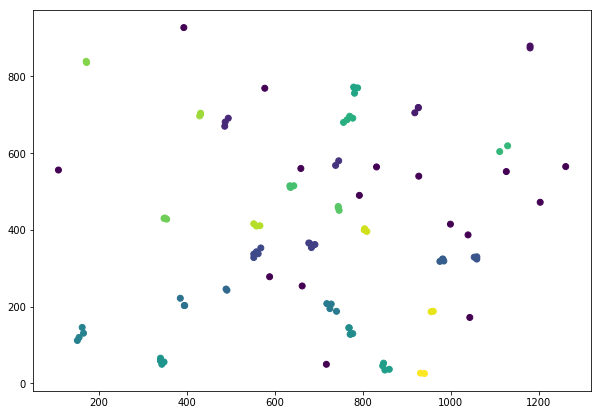

In [38]:
plt.figure(figsize=(10, 7))  
plt.scatter(trial1["x"], trial1["y"], c=cluster.labels_);

We can add these MS2 labels to the dataframe, and groupby later to ensure that each group does not have MS2 dots from the same timepoint.

Remember, each group should not have points from the same timepoint, because we are grouping all MS2 from all timepoints to validate whether the MS2 coordinates we found earlier are actually MS2 dot coordinates and not random noise.

- If the coordinates are actually identifying a MS2 dot, then there should be multiple coodinates clustered around the same area for all timepoints.

- If there is a lone coordinate cluster, then this indicates that it could likely be random noise.

In [39]:
trial1["DBSCAN_labels"] = lab
trial1.head()

,x,y,timept,DBSCAN_labels
0,393.0,927.0,0.0,-1
1,1180.0,874.0,0.0,0
2,918.0,705.0,0.0,1
3,486.0,670.0,0.0,2
4,738.0,568.0,0.0,3


In [40]:
#can check (notice that none of the aggregated points are from the same timepoint--so no overlaps)
trial1[["DBSCAN_labels", "timept"]].groupby("DBSCAN_labels").agg(list)

,timept
DBSCAN_labels,
-1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, ..."
0,"[0.0, 1.0]"
1,"[0.0, 2.0, 3.0]"
2,"[0.0, 1.0, 2.0]"
3,"[0.0, 4.0]"
4,"[0.0, 1.0, 2.0, 3.0, 4.0]"
5,"[0.0, 1.0, 2.0, 3.0, 4.0]"
6,"[0.0, 1.0, 2.0, 3.0]"
7,"[0.0, 1.0, 2.0, 3.0]"


# Nucleus 

Now that we have the MS2 dot coordates and have identified groupings for each of these dots, we can move on to clustering the nucleuses.

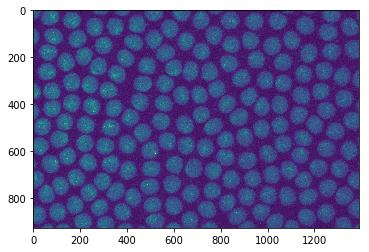

In [41]:
#using the same array we read in: 
zstack = array1[1, 1, :, ...] #(timepoint, channel, etc.) this one is timepoint 1
zstack.shape

zstack_MAX= np.max(zstack, axis=0)
plt.imshow(zstack_MAX)
plt.show()

/Users/samanthatang/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


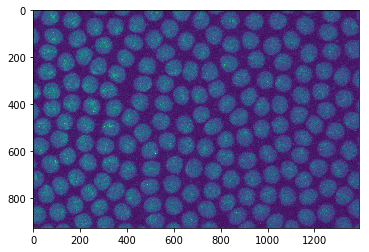

In [42]:
# Convert to 8bit
zstack_MAX_8bit = img_as_ubyte(zstack_MAX)
plt.figure()
plt.imshow(zstack_MAX_8bit);

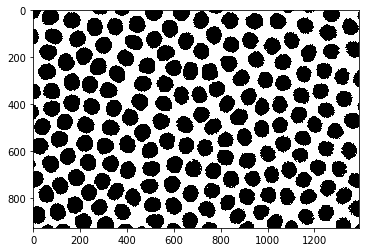

In [43]:
#### PART 1: Find centers with a conservative threshold
### First perform the conservative threshold on every point in the Z axis with the Otsu threshold
zstack_MAX_8bit_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 1) # blur image and remove noise

otsuthresh = filters.threshold_otsu(zstack_MAX_8bit_GausFilt) # grey scale 
zstack_MAX_8bit_GausFilt_localtheshold = zstack_MAX_8bit_GausFilt > otsuthresh

plt.figure()
plt.imshow(zstack_MAX_8bit_GausFilt_localtheshold, cmap = "Greys");

## Calling the Centers

- [Euclidean distance transform](https://medium.com/on-coding/euclidean-distance-transform-d37e06958216)

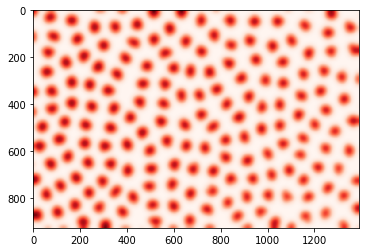

In [44]:
#### Then Call centers 
### Distance transform
distancetransform_combined_final = ndi.distance_transform_edt(zstack_MAX_8bit_GausFilt_localtheshold)

#### smoothen the distance transform
distancetransform_combined_final_gaus = ndi.filters.gaussian_filter(distancetransform_combined_final, 10)

plt.figure()
plt.imshow(distancetransform_combined_final_gaus, cmap = "Reds");

In [45]:
#### Retrieve the local maxima from the distance transform
## Gives a true false for every pixel if it is the max local peak?
Local_max = feature.peak_local_max(distancetransform_combined_final_gaus, indices = False, min_distance = 40)
Local_max_bigger = ndi.filters.maximum_filter(Local_max, size=20)

#makes a mask so that I can visualize on top of the original image
Local_max_mask = np.ma.array(Local_max_bigger, mask=Local_max_bigger==0)

#Add that mask back into the watershed image
CenterPointArrays = Local_max_bigger

In [46]:
#### PART 2: Now make a mask with a permissive threshold that goes all the way to the edges of the nuclei.
image_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 20)
localthresh = filters.threshold_local(image_GausFilt, 41)
image_GausFilt_localtheshold = image_GausFilt > localthresh
image_GausFilt_localtheshold_dilate = morphology.binary_dilation(image_GausFilt_localtheshold)
EdgeMask = image_GausFilt_localtheshold_dilate

#### Part 3: watershed
## Seperate objects
CenterPointArrays_items, num = ndi.label(CenterPointArrays)

## Watershed
watershed_image = morphology.watershed(~zstack_MAX_8bit_GausFilt, CenterPointArrays_items, mask = EdgeMask)

#### Part 4: Clear borders
Watershed_ClearBorders = segmentation.clear_border(watershed_image)

### Itemize
labeled_array_segmentation, num_features_seg = ndi.label(Local_max_mask)

## Don't understand how the CenterPointArrays is actually specifying points,
## I need to figure this out so I can assign nuclei identities

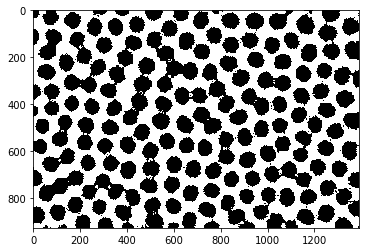

In [47]:
## EdgeMask Gaussian septerated. 
## Why not just do this instead of watershed?
EdgeMask_gauss = ndi.filters.gaussian_filter(EdgeMask, .5)
plt.figure()
plt.imshow(EdgeMask_gauss, "Greys");

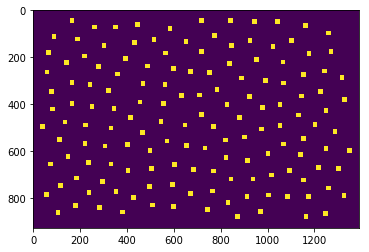

In [48]:
plt.imshow(Local_max_bigger); #located the centers

In [49]:
EdgeMask_gauss #could prob turn into 1's and 0's and gather info from there

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [50]:
binary = EdgeMask_gauss * 1 #turned into 1's and 0's 
binary

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [51]:
from skimage.feature import corner_harris, corner_foerstner, corner_peaks, corner_subpix

Initially, the thought process was to determine the outer edge coordinates of each nucleus. From there we could use these edge coordinates to determine if our MS2 coordinates lie within these nucleuses. But it can be difficult to calculate this since we don't have exact, continuous border coordinates (see image below)

In [52]:
coords = corner_peaks(corner_harris(binary), min_distance=1)
coords

/Users/samanthatang/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


array([[   1,    1],
       [   1,   25],
       [   1,   54],
       ...,
       [ 926, 1130],
       [ 926, 1288],
       [ 926, 1364]])

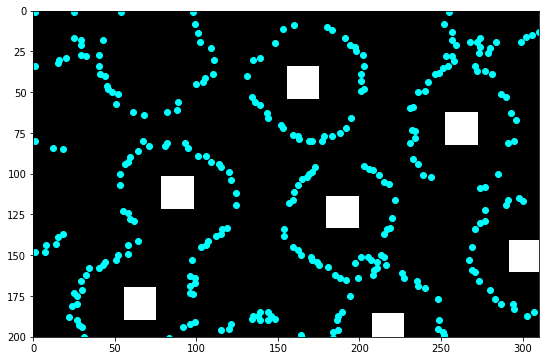

In [54]:
coords_subpix = corner_subpix(binary, coords, window_size=13)
coords_subpix

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(binary, cmap=plt.cm.gray)
ax.imshow(Local_max_bigger, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',linestyle='None', markersize=6)
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 310, 200, 0)) #subset/closer look cuz too much if full size (top upper left corner)
plt.show()

Clustering the centers

As such, I also looked into gathering the coordinates for every single center and clustering these centers using the same DBSCAN algorithm above. The results were pretty good, and we did determine that the array1 image we were using had about 148 centers (excluding any cut off center/nucleuses on the edges of the original image)


In [58]:
#get center coordinates (each center is equal to 1), 
#and the coordinates are the indices for row and column of the 1 value in matrix

y_len = len(Local_max_bigger)
x_len = len(Local_max_bigger[1])
centersX = []
centersY = []
for j in range(y_len): 
    for i in range(x_len):
        if Local_max_bigger[j][i] > 0: 
            centersX.append(i)
            centersY.append(j)
        

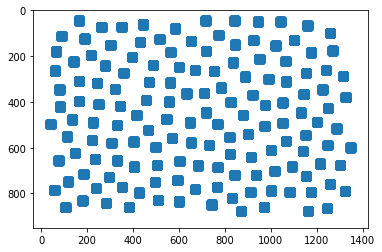

In [59]:
centers = pd.DataFrame({"x":centersX, 
                        "y": centersY})
# plt.imshow(EdgeMask_gauss, "Greys");
plt.scatter(centers["x"], centers["y"])
plt.ylim([950, 0]);
# plt.axis((0, 310, 200, 0)); #notice that centers are all squares

In [60]:
cluster_ft = DBSCAN(eps=1, min_samples=4) 
labels = cluster_ft.fit_predict(centers)
labels

array([  0,   0,   0, ..., 147, 147, 147])

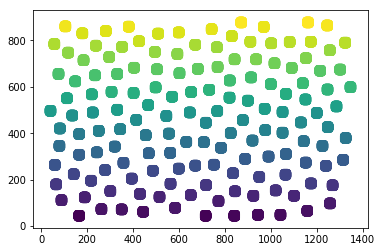

In [61]:
plt.figure()
plt.scatter(centers["x"], centers["y"], c=cluster_ft.labels_);
#it's hard to tell that they are different, but the colors 
#are different shades (otherwise it would look like above)
#indicating different clusters = 147 total unique ones 

In [62]:
np.unique(labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147])

In [63]:
centers["center_labels"] = labels


In [64]:
centers.head()

,x,y,center_labels
0,156,35,0
1,157,35,0
2,158,35,0
3,159,35,0
4,160,35,0


Clustering nucleus

Naturally, I also looked into how I could cluster the nucleuses. Using the same/similar method above, I extracted all the coordinates/pixels that made up a nucleus (see below). I also tried clustering these points, but it was difficult to do because of overlaps. However, I did come across a method called spectral clustering which seems promising, but I don't have the necessary computing power for it to run on the entire image. I've sampled this method on a section of the image array and it seems to do pretty well in separating overlaps.

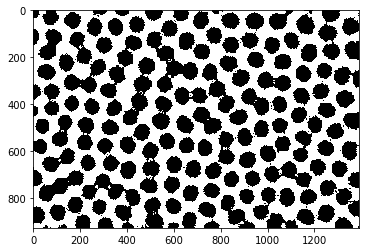

In [43]:
plt.imshow(EdgeMask_gauss, "Greys");

In [44]:
y_len = len(EdgeMask_gauss)
x_len = len(EdgeMask_gauss[1])
nucX = []
nucY = []
for j in range(y_len): 
    for i in range(x_len):
        if EdgeMask_gauss[j][i] > 0: 
            nucX.append(i)
            nucY.append(j)
      

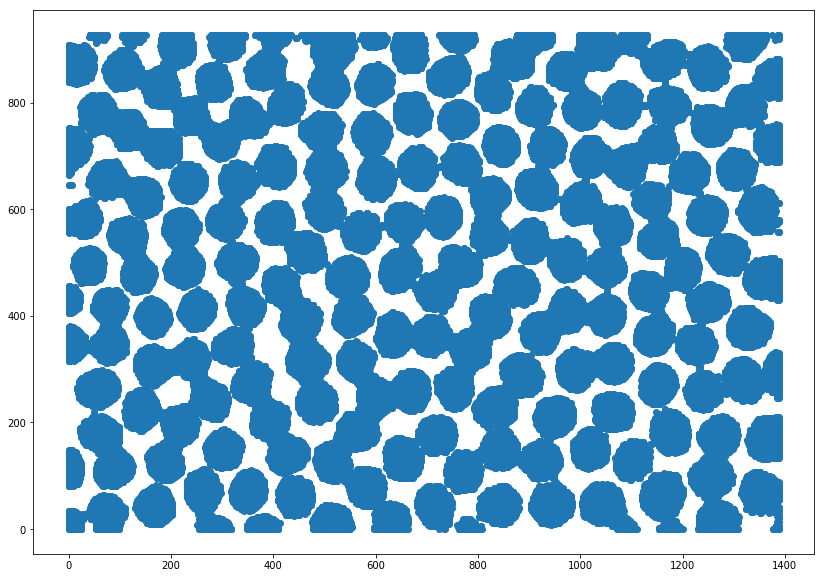

In [45]:
nuc = pd.DataFrame({"x":nucX, 
                    "y": nucY})
# plt.imshow(EdgeMask_gauss, "Greys");
plt.figure(figsize=(14, 10))
plt.scatter(nuc["x"], nuc["y"]);
# plt.ylim([950, 0]);
# plt.axis((0, 310, 200, 0)); #notice that centers are all squares

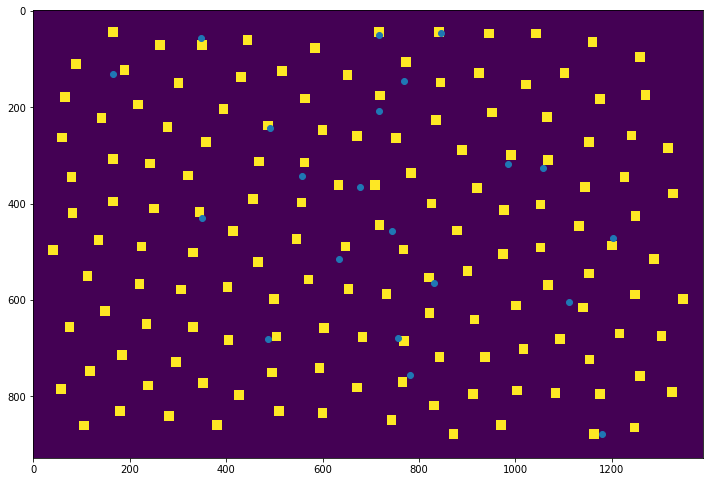

In [46]:
timepoint1 = trial1[trial1["timept"] == 1] #test with these since above is only for 1 timepoint of array1

plt.figure(figsize=(12, 10))
plt.imshow(Local_max_bigger) #centers
# plt.imshow(EdgeMask_gauss) #nucleus 
plt.scatter(timepoint1["x"], timepoint1["y"]); #points (for timepoint1)

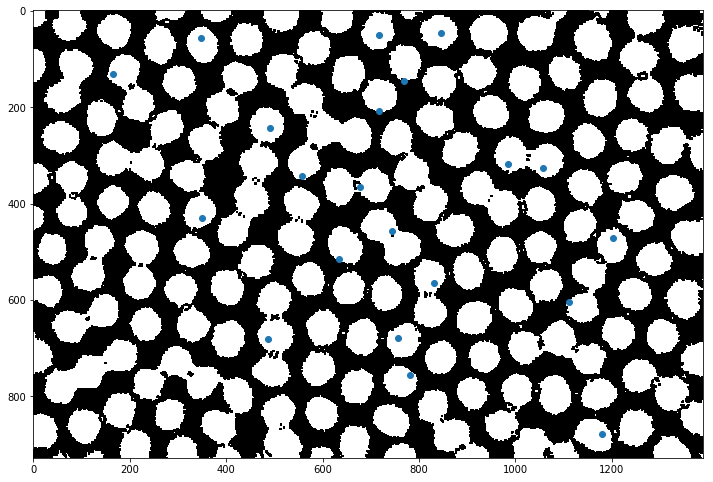

In [47]:
plt.figure(figsize=(12, 10))
plt.imshow(EdgeMask_gauss, cmap="gray") #nucleus 
plt.scatter(timepoint1["x"], timepoint1["y"]); #points (for timepoint1)

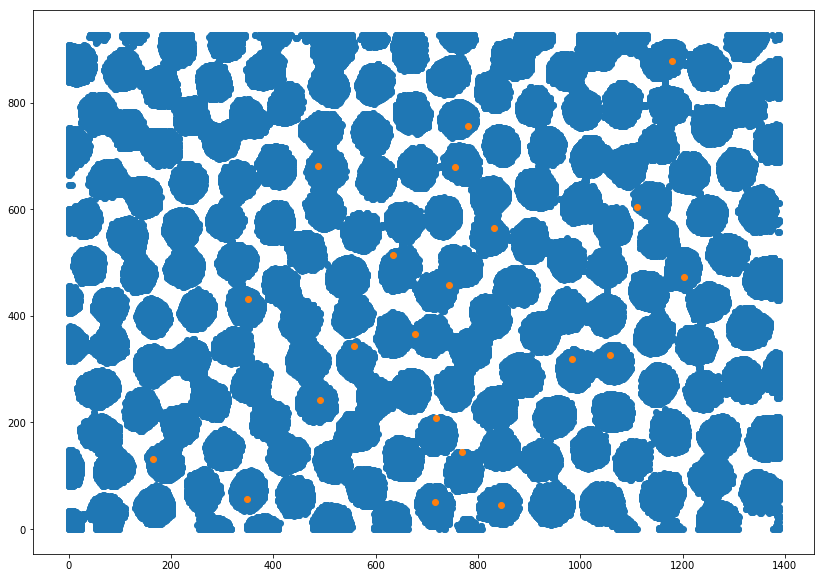

In [48]:
plt.figure(figsize=(14, 10))
plt.scatter(nuc["x"], nuc["y"]);
plt.scatter(timepoint1["x"], timepoint1["y"]); #points (for timepoint1)
# plt.axis((150, 250, 100, 250));

#same as above pic, just different nucleus background and axes are flipped

Spectral Clustering: https://scikit-learn.org/stable/auto_examples/cluster/plot_segmentation_toy.html (will be very useful for separating blobs between each other and not between background) -- see below for their example

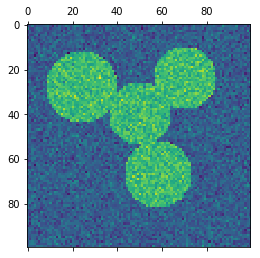

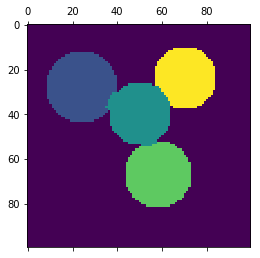

In [49]:
#citation: code from scikit-learn
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

plt.matshow(img);
plt.matshow(label_im);

Above was example code extracted from ski-image, now we try this on a section of our image below.

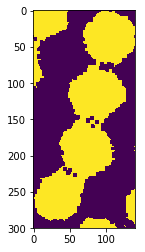

In [50]:
plt.imshow(zstack_MAX_8bit[200:500, 380:520]);
plt.imshow(EdgeMask_gauss[200:500, 380:520]);

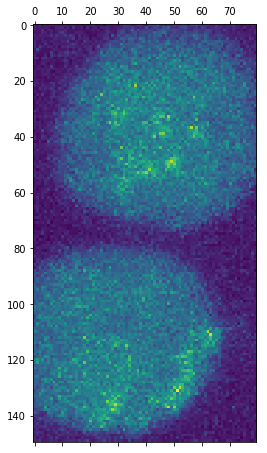

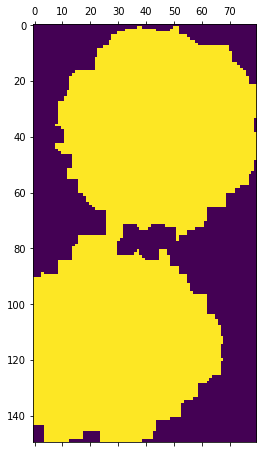

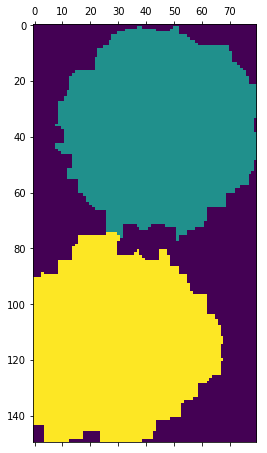

In [51]:

# (440, 520, 350, 200) x, y
img = zstack_MAX_8bit[200:350, 440:520] #y, x
mask = EdgeMask_gauss[200:350, 440:520]
img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*EdgeMask_gauss[200:350, 440:520].shape)

graph = image.img_to_graph(img, mask=mask)

graph.data = np.exp(-graph.data / graph.data.std())

#need to know exactly how many clusters, otherwise, won't cluster correctly (i.e. 2 cluster vs. 3 cluster try)
labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack') #gives labels for points

label_im = np.full(mask.shape, -1.) #create temp image of mask
label_im[mask] = labels #assign the labels to the image

plt.matshow(img);
plt.matshow(mask);
plt.matshow(label_im); #plot the image of labels 

In [52]:
labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

So by the end of this, we have a couple of things accomplished: 

- We have the coordinates of the MS2 dots for all timepoints
- We have the group labels of the MS2 dots for all timepoints
- We have the coordinats of all the pixels that make up all the centers
- We have the coordinates of all the pixels that make up the nucleus

Our next steps: 

- Figure out how to associate the MS2 dots with the nucleus and/or centers
- Combine the dataframes and group the pixels that make up the nucleus/centers together
- Compute the clusters/cluster labels for the nucleuses

There's also a couple of things we need to go back and improve on once we get to the last stage of constructing a full dataframe/dataset: 

- Figure out how to automate the threshold value for clustering, blob detection, and other algorithms
- How to consolidate this entire process into one big function or method
- Construct better visualizations of this process